In this notebook, we will use LSTM to predict stock price (more precisely, we are interested in the rise and fall of a stock price based on previous information) in Keras. I will also use more than one feature in my model, and it could be interesting for you to see how we can create the LSTM input data shape required by Keras in this case.

Moreover, we are going to implement a manual Grid Search to tune the hyperparameters. We will also take advantage of Early Stopping and Callback to reduce the hyperparameter tunning time. To the best of my knowledge, the tunned model has the best result on this data in the Kaggle.

## Contents

* [Import Libraries and the Data](#1)
* [Descriptive Analysis](#2)
    - [Number of unique stock symbols](#21)
    - [Choosing a Random Stock Symbol](#22)
    - [plotting Price through Time](#23)
    - [Fearure Scaling](#24)
    - [Creating LSTM input data](#25)
* [Train LSTM Model](#3)
* [Hyperparameter Tunning](#4)
    - [Introduction](#41)
    - [Grid Search](#42)
    - [Early Stopping and Callback](#43)
    - [Choosing the Best Model](#44)
* [Results](#5)

<a id="1"></a> <br>
## Import Libraries and the Data

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os
import keras

for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./volume.png
./Kaggle-problem presentation.docx
./2330_TW.csv
./best_model.keras
./驗證用.csv
./stock-price-prediction-lstm-hyperparameter-tuning.ipynb
./output.png
./data.png
./Kaggle-problem presentation.pdf
./2010.1.1~2024.4.1/^SOX(費城半導體).csv
./2010.1.1~2024.4.1/2330.TW(股息).csv
./2010.1.1~2024.4.1/TSM(ADR).csv
./2010.1.1~2024.4.1/2330.TW.csv
./.venv/pyvenv.cfg
./.venv/.gitignore
./.venv/bin/wheel3.11
./.venv/bin/import_pb_to_tensorboard
./.venv/bin/pyftsubset
./.venv/bin/markdown_py
./.venv/bin/jupyter-run
./.venv/bin/wheel3
./.venv/bin/activate.ps1
./.venv/bin/toco_from_protos
./.venv/bin/python3
./.venv/bin/ttx
./.venv/bin/python
./.venv/bin/pip3
./.venv/bin/ipython
./.venv/bin/pip-3.11
./.venv/bin/activate.fish
./.venv/bin/fonttools
./.venv/bin/wheel
./.venv/bin/python3.11
./.venv/bin/tf_upgrade_v2
./.venv/bin/wheel-3.11
./.venv/bin/activate_this.py
./.venv/bin/f2py
./.venv/bin/ipython3
./.venv/bin/pip
./.venv/bin/markdown-it
./.venv/bin/pip3.11
./.venv/bin/jupyter-troubleshoot
./.v

In [8]:
tsmc =  pd.read_csv('./2010.1.1~2024.4.1/2330.TW.csv', header=0)
tsmc = tsmc.dropna(axis=0, thresh=tsmc.shape[1])
tsmc.shape[1]

7

In [9]:
tsm = pd.read_csv('./2010.1.1~2024.4.1/TSM(ADR).csv', header=0)
tsm = tsm.dropna(axis=0, thresh=tsm.shape[1])
tsmc.shape[1]

7

In [ ]:
sox = pd.read_csv('./^SOX(費城半導體).csv', header=0)

<a id="2"></a> <br>
## Descriptive Analysis

In [4]:
data.head()

,date,symbol,open,close,low,high,volume
0,2010/1/4,TSMC,65.000000,64.900002,64.000000,65.000000,39407000.0
1,2010/1/5,TSMC,65.000000,64.500000,63.900002,65.099998,37138000.0
2,2010/1/6,TSMC,64.500000,64.900002,63.700001,64.900002,49261000.0
3,2010/1/7,TSMC,64.900002,64.199997,64.199997,65.000000,42134000.0
4,2010/1/8,TSMC,63.500000,64.000000,63.500000,64.300003,46076000.0


In [5]:
print(data.columns)
print(data.shape)

Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume'], dtype='object')
(3485, 7)


In [6]:
data.iloc[:, 2:-1].describe()

,open,close,low,high
count,3485.000000,3485.000000,3485.000000,3485.000000
mean,255.528666,255.461865,253.498393,257.286485
std,188.379134,188.252477,186.898072,189.588331
min,57.599998,57.200001,57.000000,57.900002
25%,103.500000,103.500000,102.500000,104.500000
50%,187.000000,187.000000,186.000000,188.000000
75%,418.500000,416.000000,409.000000,423.500000
max,795.000000,785.000000,779.000000,796.000000


In [7]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3485 entries, 0 to 3489
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3485 non-null   object 
 1   symbol  3485 non-null   object 
 2   open    3485 non-null   float64
 3   close   3485 non-null   float64
 4   low     3485 non-null   float64
 5   high    3485 non-null   float64
 6   volume  3485 non-null   float64
dtypes: float64(5), object(2)
memory usage: 217.8+ KB


<a id="21"></a> <br>
## Number of unique stock symbols

In [8]:
print(len(data['symbol'].unique()))
symbols = data['symbol'].unique()

1


In [9]:
data['symbol'].describe()

count     3485
unique       1
top       TSMC
freq      3485
Name: symbol, dtype: object

<a id="22"></a> <br>
## Choosing a Random Stock Symbol

In [10]:
# random.seed(42)  #explain!
choosen_symbol = random.choice(symbols)
print(choosen_symbol)

TSMC


In [11]:
data_prices = data[data['symbol'] == choosen_symbol].reset_index(drop = True)
data_prices.iloc[:10, :]

,date,symbol,open,close,low,high,volume
0,2010/1/4,TSMC,65.000000,64.900002,64.000000,65.000000,39407000.0
1,2010/1/5,TSMC,65.000000,64.500000,63.900002,65.099998,37138000.0
2,2010/1/6,TSMC,64.500000,64.900002,63.700001,64.900002,49261000.0
3,2010/1/7,TSMC,64.900002,64.199997,64.199997,65.000000,42134000.0
4,2010/1/8,TSMC,63.500000,64.000000,63.500000,64.300003,46076000.0
5,2010/1/11,TSMC,64.000000,64.500000,63.500000,64.900002,36799000.0
6,2010/1/12,TSMC,64.400002,63.599998,63.299999,64.400002,49853000.0
7,2010/1/13,TSMC,63.000000,62.799999,62.599998,63.099998,47976000.0
8,2010/1/14,TSMC,63.599998,63.200001,63.000000,63.599998,36149000.0
9,2010/1/15,TSMC,62.900002,63.500000,62.799999,63.500000,47852000.0


In [12]:
data_prices = data_prices.drop(['date', 'symbol'], axis=1)

<a id="23"></a> <br>
## plotting Price through Time

While the first big plot shows opening, closing, low, and high price altogether, the following four plots show each attribute separately. It may seem that all of the mentioned prices are the same, but as it is clear in the first big plot, they have a slight difference with each other.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


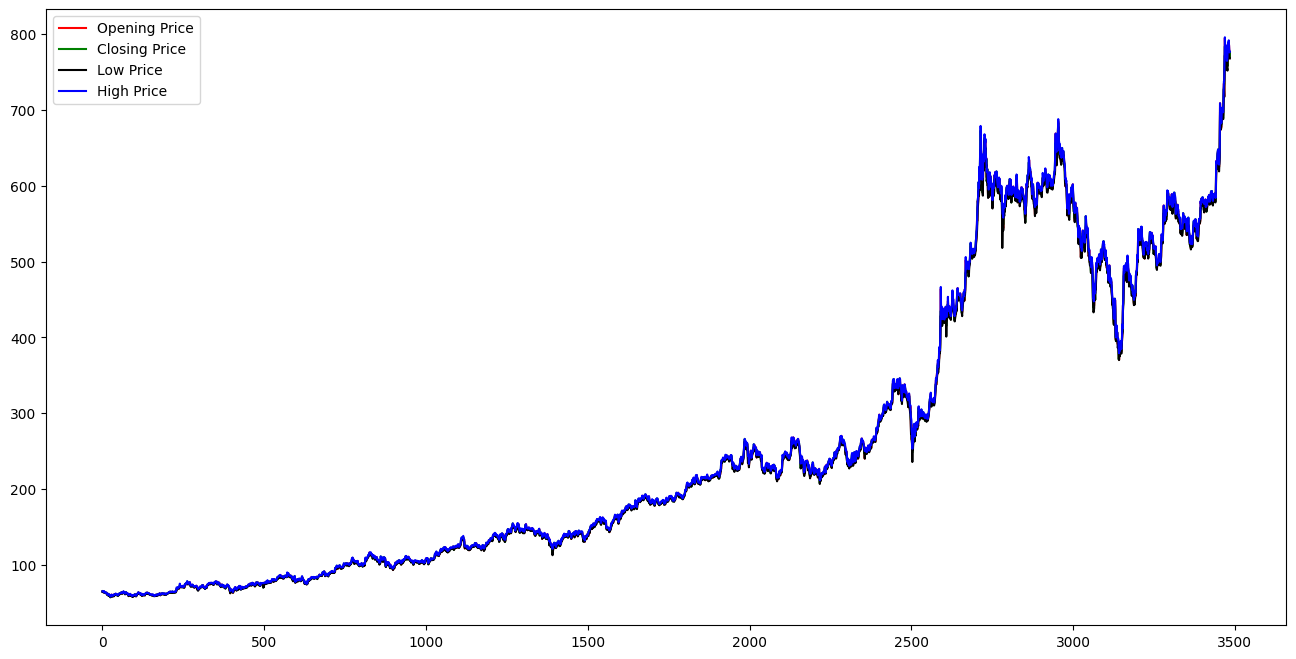

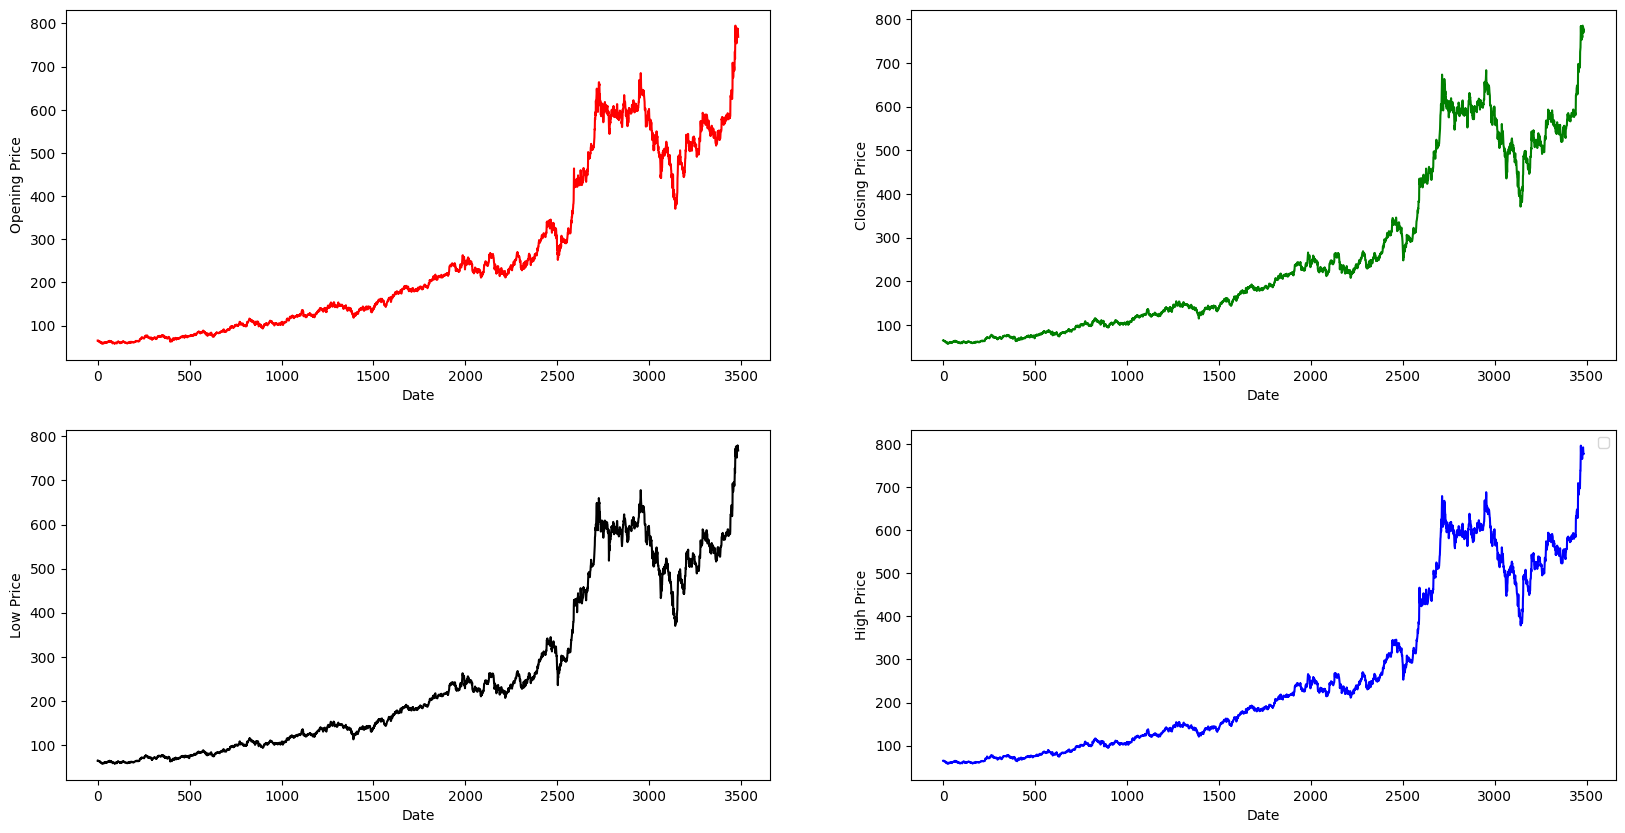

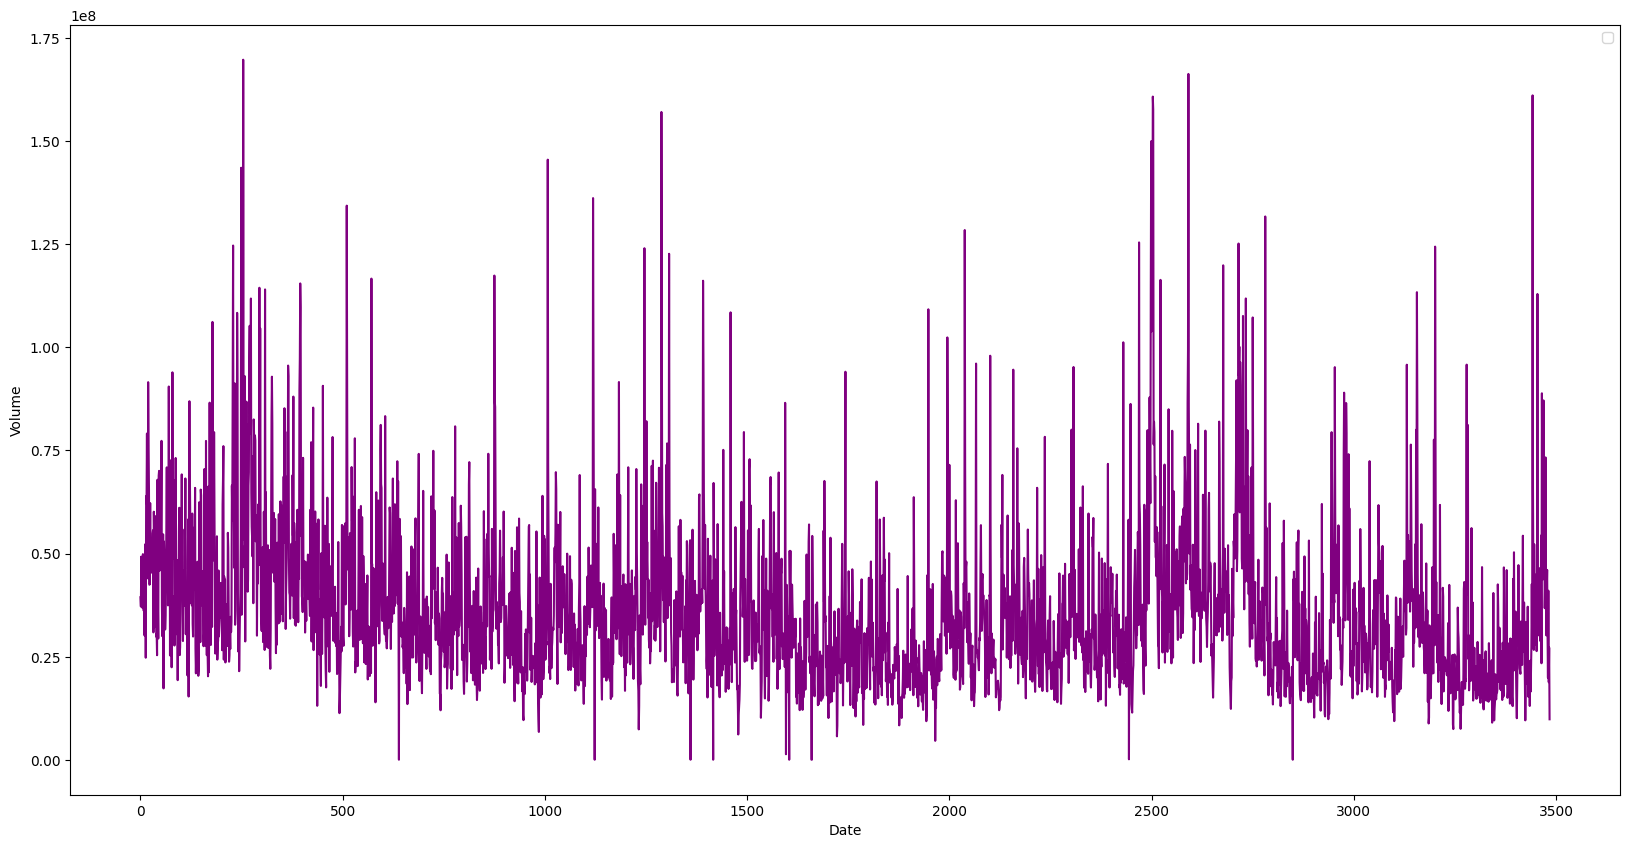

In [13]:
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(data_prices['open'], color='red', label = 'Opening Price')
plt.plot(data_prices['close'], color='green', label = 'Closing Price')
plt.plot(data_prices['low'], color='black', label = 'Low Price')
plt.plot(data_prices['high'], color='blue', label = 'High Price')
plt.legend(loc='best')

plt.subplots(2, 2, figsize = (20, 10))

ax1 = plt.subplot(2, 2, 1)
plt.plot(data_prices['open'], color='red')
plt.xlabel('Date')
plt.ylabel('Opening Price')

ax2 = plt.subplot(2, 2, 2)
plt.plot(data_prices['close'], color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price')

ax3 = plt.subplot(2, 2, 3)
plt.plot(data_prices['low'], color='black')
plt.xlabel('Date')
plt.ylabel('Low Price')

ax4 = plt.subplot(2, 2, 4)
plt.plot(data_prices['high'], color='blue')
plt.xlabel('Date')
plt.ylabel('High Price')

plt.legend(loc='best')

plt.figure(figsize=(20, 10))
plt.plot(data_prices["volume"], color="purple")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend(loc="best")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15120\3608199628.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('coolwarm')  # 你可以选择任何喜欢的颜色映射
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15120\3608199628.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


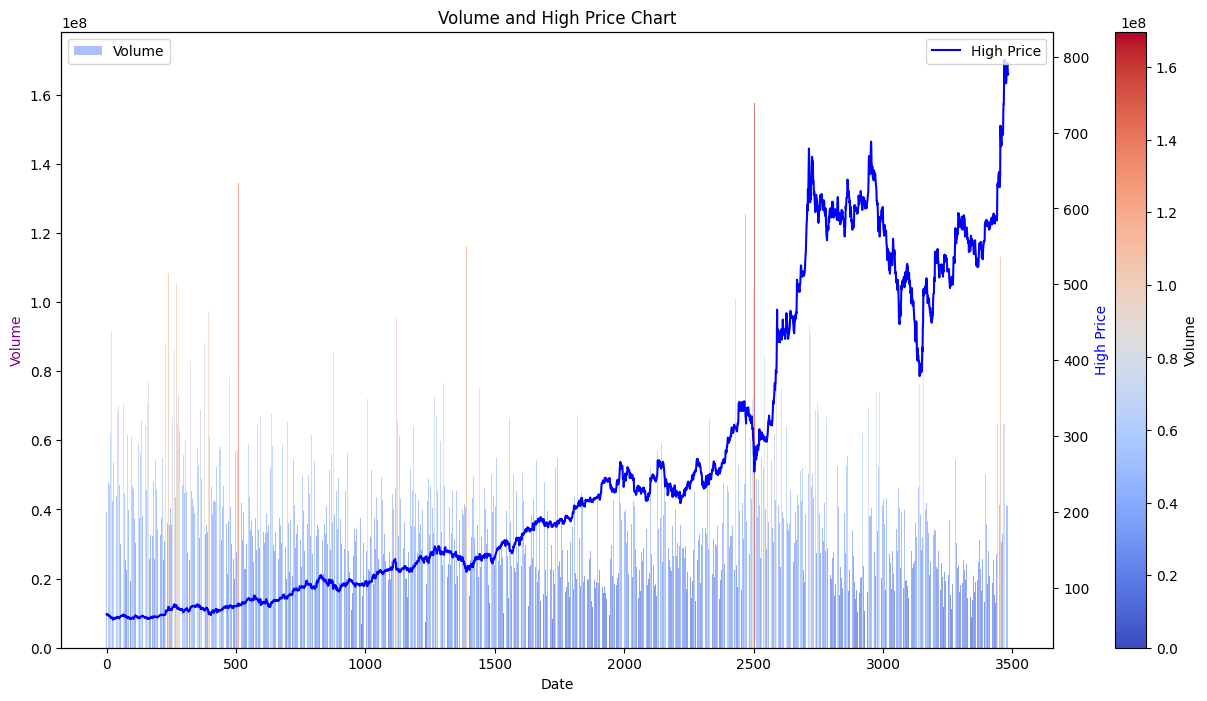

In [17]:
import matplotlib.pyplot as plt
import numpy as np

dates = data_prices.index
volumes = data_prices['volume']
high_prices = data_prices['high']

color_map = plt.cm.get_cmap('coolwarm') 
norm = plt.Normalize(volumes.min(), volumes.max())

fig, ax1 = plt.subplots(figsize=(16, 8))

bar_colors = color_map(norm(volumes))
bars = ax1.bar(dates, volumes, color=bar_colors, label='Volume', alpha=0.7)


sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Volume')

ax2 = ax1.twinx()
ax2.plot(dates, high_prices, color='blue', label='High Price')


ax1.set_xlabel('Date')
ax1.set_ylabel('Volume', color='purple')
ax2.set_ylabel('High Price', color='blue')
plt.title('Volume and High Price Chart')


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


We choose the opening price and volume as two attributes to consider in our model.

In [82]:
# data_prices = data_prices.drop(['close', 'low', 'high'], axis=1)

<a id="24"></a> <br>
## Fearure Scaling

In [83]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
data_prices_scaled = sc.fit_transform(data_prices)

In [84]:
data_prices_scaled.shape

(3485, 5)

<a id="25"></a> <br>
## Creating LSTM input data

In order to use LSTM, our input and output data should have a specific shape. It was a bit complicated for me when I was first introduced to LSTM, but I found [this](https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e) comprehensive article to fully understand what was going on. In a nutshell, the input and output data in an LSTM model is a three-dimensional array where the first dimension represents **the number of samples (or batch size)** like the number of rows of data in a two-dimensional setting, the second dimension stands for **time steps** which indicates the amount of time that we want to go back through time, and the third dimension shows **the number of features (or input dimension)** that we want to include in the model for every element in our batch. So, it is like [number_of_samples, time_steps, input_dim]. The below image is retrieved from the mentioned article and could be a good illustration of the LSTM input and output data shape.
![](https://miro.medium.com/max/665/1*AQKRJsRdWx2HZ85H1yWoKw.png)

Sometimes we prefer to choose the validation set by ourselves. In this case, in the below code, you can pass a value in the range of (0, 1) for the validation_split_percentage when you are calling the create_data function, and use the below code to fit the model:

- model.fit(train_X, train_y, validation_data=(val_x, val_y))  # manually splitting

In my case, I rathered to use the built-in parameter (validation_split) in the fit method of the Keras library.  It considers a fraction of the training data as the validation set to evaluate loss and metrics at the end of each epoch as follow:

- model.fit(train_X, train_y, validation_split=0.3)  # automatically splitting

Here, at each point of the time, we will consider price and volume as our attributes in input_dim, and 25 days as our time_steps.

In [85]:
# Creating a data structure (it does not work when you have only one feature)
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  y_data[split_train_validation_starting_point:split_training_test_starting_point]                                             
    
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [86]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_prices_scaled, n_future=5, n_past=5, train_test_split_percentage=0.8,
                                               validation_split_percentage = 0)

In [87]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(2781, 5, 5)
(0,)
(695, 5, 5)
(2781, 1)
(0,)
(695, 1)


<a id="3"></a> <br>
## Train LSTM Model

In [88]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=5, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

/Users/patten/my_files/大學課業/大三/資料探勘/project/original/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 5, 16)          │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,605 (14.08 KB)

 Trainable params: 3,605 (14.08 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0578 - val_root_mean_squared_error: 0.2404
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0027 - root_mean_squared_error: 0.0521 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1298
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0546
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.2533e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.9828e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0422
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.9932e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/

In [90]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

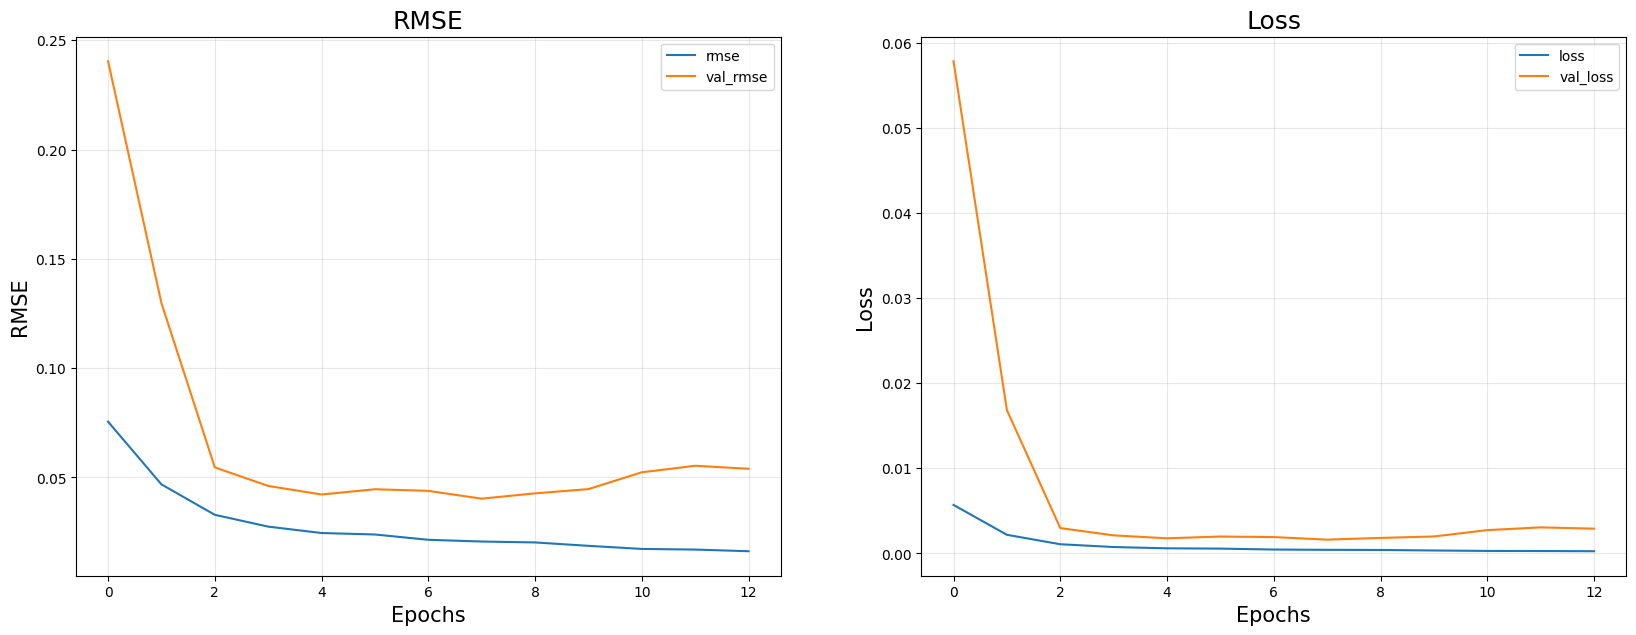

In [91]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [92]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0145 - root_mean_squared_error: 0.1198
test loss, test acc: [0.0146 0.121 ]


<a id="4"></a> <br>
## Hyperparameter Tunning


We have two important terms in machine learning referred to as **model parameter** and **model hyperparamer**. So, first of all, what is a hyperparameter, and what is a parameter? Based on [here](https://www.datacamp.com/community/tutorials/parameter-optimization-machine-learning-models),

- A model **model hyperparameter** is a configuration that is external to the model and whose value cannot be estimated from the data and a **model parameter** is a configuration variable that is internal to the model and whose value can be estimated from the given data.

In the other words, a hyperparameter is used to construct the structure of the model and cannot be learned from the data and its value is set before the learning process begins. Therefore, hyperparameters are like the settings of an algorithm that can be adjusted to optimize performance and prevent overfitting. This is exactly what we do in the hyperparameter tuning. We try to choose a set of optimal hyperparameters for a learning algorithm to enhance the performance of the model. There are two frequently used methods to perform hyperparameter tunning called 1)Grid Search and 2)Random Search. In this notebook, I have used the former one because of its simplicity to implement and at the same time, its powerful performance. More information on both of the methods can be found in [here](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85).

<a id="42"></a> <br>
## Grid Search

Grid search is a traditional method to perform hyperparameter tunning. It basically works by defining a subset of candidate values for each hyperparameter, and training all the possible combination of the hyperparameters. Then, each possible fitted model is evaluated on a validation set, and the best configuration of the hyperparameter will be choosed at the end.

<a id="43"></a> <br>
## Early Stopping and Callback

Since in the Grid Search, we have to train an LSTM model for each combination, it may take so much time to fit all the models and choose the best combination of the hyperparameters. One of the ways that we can prevent this from happening is through using Early Stopping and Callbacks. The idea here is to track a measure (like validation loss) and whenever a stopping criterion (like no improvement in the monitored measure value in successive steps, reaching a pre-specified limit for that measure, or a pre-specified increment in that measure) is satisfied, we can stop the training process. The measure that we are using here is validation loss since the validation set is not used in the training process. [This](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) article is one of the best articles that I've read about using Early Stopping to halt the training of a model at the right time. In the below, I copied and pasted the parts that I found important:

> 1. **es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)** ****-->**** Often, the first sign of no further improvement may not be the best time to stop training. This is because the model may coast into a plateau of no improvement or even get slightly worse before getting much better. We can account for this by adding a delay to the trigger in terms of the number of epochs on which we would like to see no improvement. This can be done by setting the “patience” argument.
    
> 2. **es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)** **-->** By default, any change in the performance measure, no matter how fractional, will be considered an improvement. You may want to consider an improvement that is a specific increment, such as 1 unit for mean squared error or 1% for accuracy. This can be specified via the “min_delta” argument.

> 3. **es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.4)** **-->**  Finally, it may be desirable to only stop training if performance stays above or below a given threshold or baseline. For example, if you have familiarity with the training of the model (e.g. learning curves) and know that once a validation loss of a given value is achieved that there is no point in continuing training. This can be specified by setting the “baseline” argument.
    
> 4. **mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)** **-->** The EarlyStopping callback will stop training once triggered, but the model at the end of training may not be the model with best performance on the validation dataset. An additional callback is required that will save the best model observed during training for later use. This is the ModelCheckpoint callback.

In [93]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=5, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.keras'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [95]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]  

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00392, saving model to best_model.keras

Epoch 2: val_loss did not improve from 0.00392

Epoch 3: val_loss improved from 0.00392 to 0.00378, saving model to best_model.keras

Epoch 4: val_loss improved from 0.00378 to 0.00316, saving model to best_model.keras

Epoch 5: val_loss improved from 0.00316 to 0.00230, saving model to best_model.keras

Epoch 6: val_loss improved from 0.00230 to 0.00212, saving model to best_model.keras

Epoch 7: val_loss did not improve from 0.00212

Epoch 8: val_loss did not improve from 0.00212

Epoch 9: val_loss did not improve from 0.00212

Epoch 10: val_loss improved from 0.00212 to 0.00189, saving model to best_mo

<a id="44"></a> <br>
## Choosing the Best Model

In [96]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
4,False,False,False,32,16,0.2,"[0.00033137790160253644, 0.01820378750562668]","[0.004104265011847019, 0.06406453996896744]"
3,False,False,False,32,8,0.2,"[0.0004437163006514311, 0.021064573898911476]","[0.005450131371617317, 0.07382500171661377]"
5,False,False,False,32,32,0.2,"[0.0005056494846940041, 0.022486651316285133]","[0.007390292827039957, 0.0859668105840683]"
1,False,False,False,16,16,0.2,"[0.0008264530915766954, 0.028748096898198128]","[0.0123133584856987, 0.11096557229757309]"
2,False,False,False,16,32,0.2,"[0.0010565356351435184, 0.03250439465045929]","[0.01729729399085045, 0.13151918351650238]"
0,False,False,False,16,8,0.2,"[0.0011932449415326118, 0.03454337641596794]","[0.019550789147615433, 0.13982413709163666]"


<a id="5"></a> <br>
## Results

In [97]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 32
 n_batch_size = 16
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.121

Results After Tunning:
 Test Set RMSE: 0.0641

47.0% Improvement


In [98]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [99]:
print(type(n_neurons))
n_neurons = int(n_neurons)
print(type(n_neurons))

<class 'numpy.int64'>
<class 'int'>


In [134]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=5, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.keras'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

/Users/patten/my_files/大學課業/大三/資料探勘/project/original/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00083, saving model to best_model.keras

Epoch 2: val_loss did not improve from 0.00083

Epoch 3: val_loss did not improve from 0.00083

Epoch 4: val_loss did not improve from 0.00083

Epoch 5: val_loss did not improve from 0.00083

Epoch 6: val_loss did not improve from 0.00083
Epoch 6: early stopping


In [135]:
regressor.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075


0.007862135767936707

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


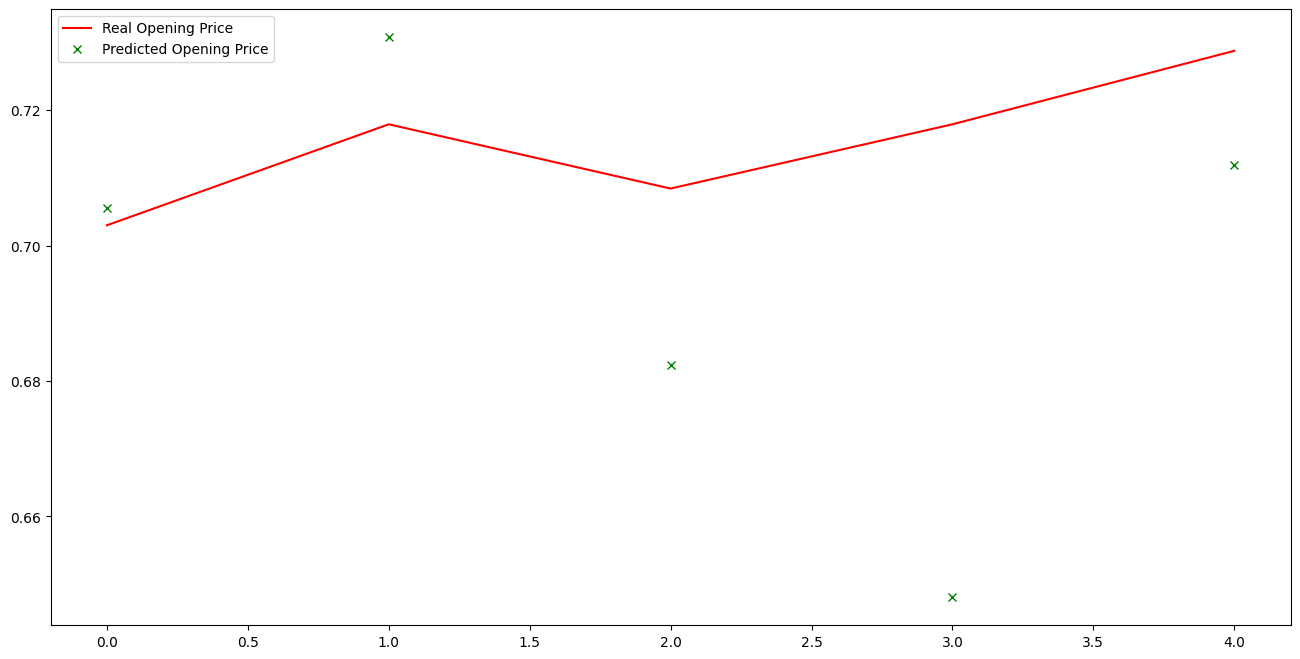

In [136]:
regressor = keras.models.load_model("best_model.keras")
y_pred = regressor.predict(np.expand_dims(X_test[0], axis=0))
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test[0:5], color='red', label = 'Real Opening Price')
plt.plot(np.arange(0, 5), y_pred[0], "gx", label = 'Predicted Opening Price')
plt.legend(loc='best')

As it is clear in the plot, the trend (rise and fall) of the stock price is well predicted. Nice!

In [137]:
print(y_pred.shape)

(1, 5)


In [138]:
y_pred_new = []
print(y_pred)
for i in range(len(y_pred[0])):
    y_pred_new.append([y_pred[0][i], y_pred[0][i], y_pred[0][i], y_pred[0][i], y_pred[0][i]])
print(y_pred_new)
for i in range(len(y_pred_new)):
    print(sc.inverse_transform(y_pred_new)[i][0])

[[0.705555   0.73078275 0.68242204 0.64805657 0.71190464]]
[[0.705555, 0.705555, 0.705555, 0.705555, 0.705555], [0.73078275, 0.73078275, 0.73078275, 0.73078275, 0.73078275], [0.68242204, 0.68242204, 0.68242204, 0.68242204, 0.68242204], [0.64805657, 0.64805657, 0.64805657, 0.64805657, 0.64805657], [0.71190464, 0.71190464, 0.71190464, 0.71190464, 0.71190464]]
577.8762724590341
596.4791972974878
560.8180130567463
535.4769115919314
582.5584846218302


# If you liked my work then please upvote, Thank you.

In [139]:
# Creating a data structure (it does not work when you have only one feature)
def create_data_2(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    x_data.append(df[len(df) - n_past:len(df), 0:n_feature])
    
    return np.array(x_data)

In [140]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_data = create_data_2(data_prices_scaled, n_future=5, n_past=5, train_test_split_percentage=0.8,
                                               validation_split_percentage = 0)

In [141]:
print(X_data.shape)

(1, 5, 5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


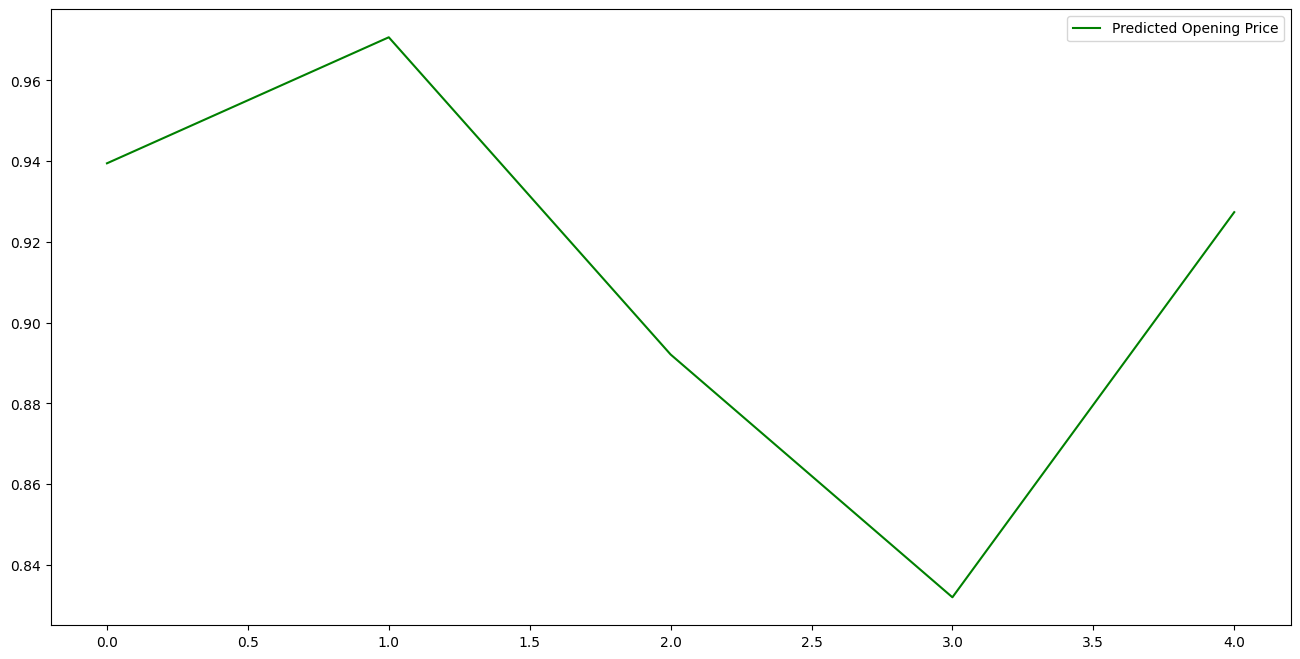

In [142]:
regressor = keras.models.load_model("best_model.keras")
y_pred = regressor.predict(np.expand_dims(X_data[0], axis=0))

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_pred[0], color="green", label = 'Predicted Opening Price')
plt.legend(loc='best')

In [143]:
print(y_pred.shape)

(1, 5)


[0.9394717, 0.9394717, 0.9394717, 0.9394717, 0.9394717]
750.3664474230413
773.3791670451267
715.4648496854816
671.1306573488406
741.4477450468048
1


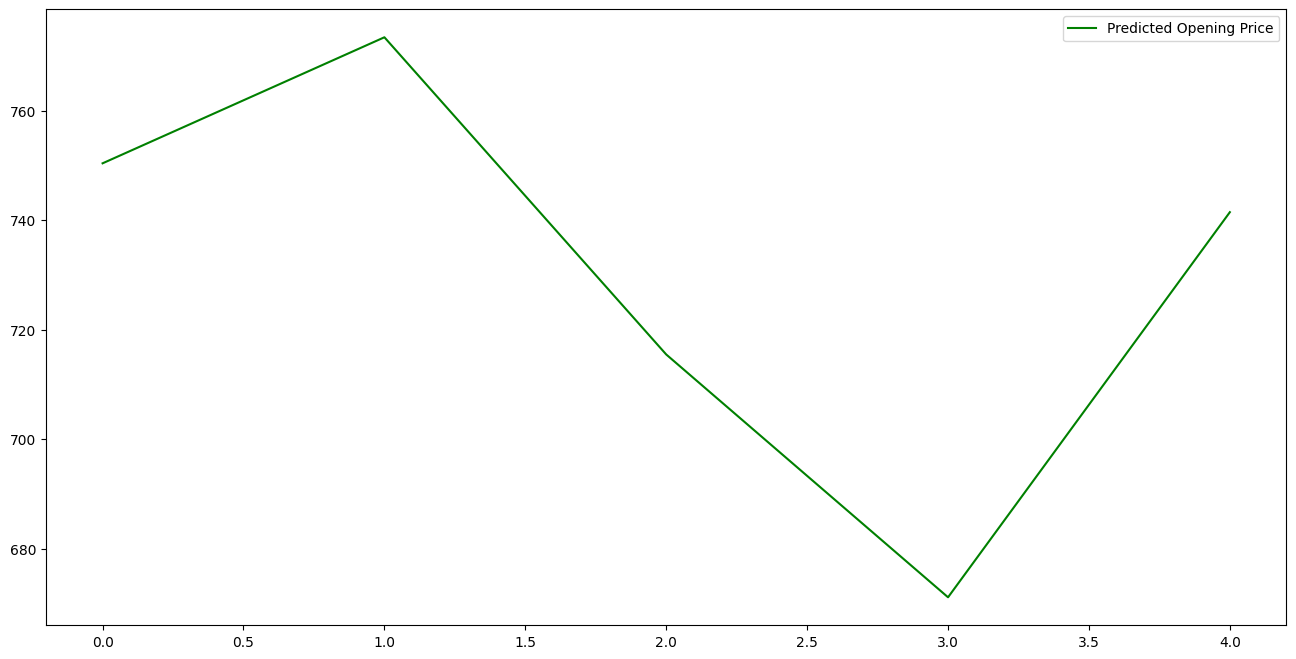

In [144]:
y_pred_new = []
for i in range(len(y_pred[0])):
    # print(y_pred[i])
    y_pred_new.append([y_pred[0][i], y_pred[0][i], y_pred[0][i], y_pred[0][i], y_pred[0][i]])
print(y_pred_new[0])
for i in range(len(y_pred_new)):
    print(sc.inverse_transform(y_pred_new)[i][0])
print(len(y_pred))
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(sc.inverse_transform(y_pred_new)[:, 0], color="green", label = 'Predicted Opening Price')
plt.legend(loc='best')